# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")

In [79]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads data

In [3]:
# Specify the filename and the path to save the file
filename = 'data_raw_unmod.h5'
save_path = "./Data"

data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ R

## Performs SHO fits

In [4]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit()

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed res

/home/ferroelectric/micromamba/envs/shofittting/lib/python3.10/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/ferroelectric/micromamba/envs/shofittting/lib/python3.10/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


## Visualize LSQF fit results

In [5]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

# instantiate the dataset object
dataset = BE_Dataset(data_path)

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [80]:
self = BE_viz

def get_selected_hysteresis(self, 
                    data, 
                   row = None, 
                   col = None,
                   cycle = None):
    
    if row is None:
        row = np.random.randint(0, data.shape[0], 1)
        
    if col is None:
        col = np.random.randint(0, data.shape[1], 1)
        
    if cycle is None:
        cycle = np.random.randint(0, data.shape[2], 1)
        
    return (row, col, cycle)

In [125]:
def hysteresis_comparison(self, 
                          data,
                          row = None,
                          col = None,
                          cycle = None,
                          size = (1.25,1.25),
                          measurement_state = None):
    
    if self.measurement_state is not None:
        self.measurement_state = measurement_state
  
    # gets the raw data
    raw_hysteresis_loop, voltage = self.dataset.get_hysteresis(loop_interpolated = True, plotting_values = True)
    
    # selects a point to plot
    row, col, cycle = get_selected_hysteresis(self, raw_hysteresis_loop, row, col, cycle)
    
    fig, ax = subfigures(1,1, size = size)
    
    ax[0].plot(voltage[:, cycle].squeeze(), 
               raw_hysteresis_loop[row, col, cycle, :].squeeze(), 'o')
    
    # add plotting here for this
    
    if 'LSQF' in data:
        parms = dataset.LSQF_hysteresis_params()[row:row+1, col:col+1, cycle:cycle+1, :].reshape(-1,9)
    
    # for data_ in data:
    #     ax.plot(data_)

In [91]:
row = 20
col = 29
cycle = 2

In [127]:
# gets the raw data
_, voltage = self.dataset.get_hysteresis(loop_interpolated = True, plotting_values = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


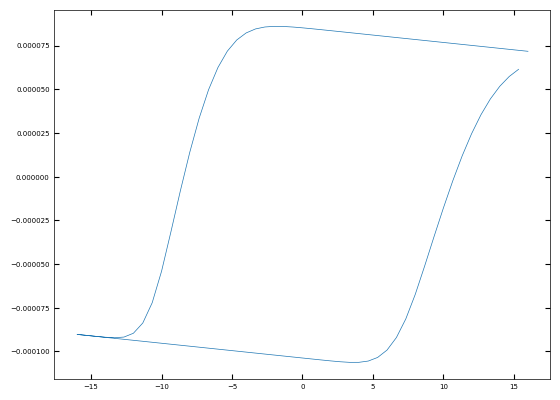

In [128]:
row = 30
col = 29
cycle = 2


votlage = dataset.get_bias_vector()
loop = loop_fitting_function_torch(voltage[:,[0]], parms).to('cpu').detach().numpy()

plt.plot(voltage[:,[0]].squeeze(), loop.squeeze())

In [95]:
parms.shape

(1, 1, 1, 9)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


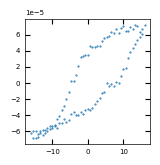

In [70]:
hysteresis_comparison(self, out)

## Neural Network Fits

In [ ]:
self = dataset

In [ ]:
from m3_learning.util.rand_util import in_list


In [ ]:
list_ = dataset.get_tree()

in_list(list_, "*SHO_Fit*")

In [ ]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            x_data, # x data
                            1, # input channels
                            9, # output parameters
                            dataset.SHO_scaler, 
                            postprocessor)

## Plot a Random Example of the fit

In [ ]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

self = BE_viz

In [ ]:
dataset.get_state

In [9]:
out, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


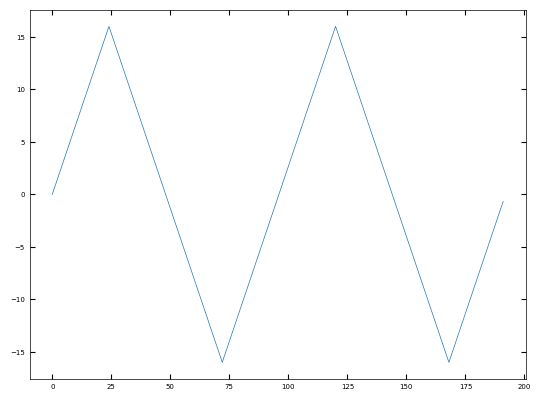

In [114]:
plt.plot(dataset.dc_voltage)

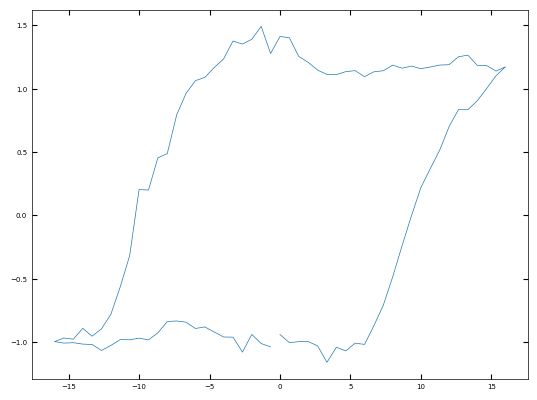

In [10]:
import matplotlib.pyplot as plt

a = np.random.randint(0,60,(1))
b = np.random.randint(0,60,(1))


plt.plot(voltage[:,0].squeeze(), out[a,b,0].squeeze())

In [11]:
hys, bias = dataset.get_hysteresis()

hys_2 = clean_interpolate(hys, axis=3)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [ ]:
def find_non_finite_indices(arr):
    non_finite_mask = ~np.isfinite(arr)
    indices = np.argwhere(non_finite_mask)
    return indices

In [ ]:
hys.shape

In [ ]:
find_non_finite_indices(hys)

In [ ]:
a

In [ ]:
import matplotlib.pyplot as plt

a = np.random.randint(0,60,(1))
b = np.random.randint(0,60,(1))


plt.plot(hys[a[0],b[0],0])
plt.plot(hys_2[a[0],b[0],0])

In [12]:
def hysteresis_fit(self, 
                   voltage, 
                   datasets, 
                   original = True,
                   row = None, 
                   col = None,
                   cycle = None):
    
    if row is None:
        row = np.random.randint(0, self.dataset.num_rows, 1)
        
    if col is None:
        col = np.random.randint(0, self.dataset.num_cols, 1)
        
    if cycle is None:
        cycle = np.random.randint(0, self.dataset.num_cycles, 1)
    
    fig, ax = subfigures(1,1, size = (1.25,1.25))
    

        

type: incomplete input (3744456558.py, line 22)

type: 'list' object has no attribute 'plot'

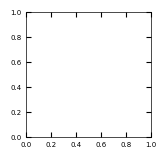

In [38]:
from m3_learning.viz.layout import layout_fig, inset_connector, add_box, subfigures, add_text_to_figure, get_axis_pos_inches, imagemap,  FigDimConverter, labelfigs, imagemap, scalebar

fig, axs = subfigures(1,1, size = (1.25,1.25))


axs.plot(V, proj_nd_shifted_transposed[i[0], i[1], :, 3],'og',
         label='initial loops')
axs.plot(V, loop_fit_results[:, i[0], i[1]], 'blue', label='fit results (NumPy)')
axs.plot(V, np.reshape(loop_fitting_function_tf(func_type, V, params), 
                       (num_pix_1d, num_pix_1d, 96))[i[0], i[1], :], 'black', 
         label='fit results (Tensorflow)')
axs.legend()
axs.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs.set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
axs.label_outer()

(60, 60, 4, 9)

In [ ]:
with h5py.File(dataset.file, "r+") as h5_f:
    
    out = h5_f['/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Fit'][:]

In [ ]:
dataset.num_cols

In [ ]:
parm = dataset.LSQF_hysteresis_params(output_shape = "index")

In [ ]:
parm.shape


In [ ]:
out, bias = dataset.get_hysteresis("/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000", plotting_values=True)
out.shape

In [76]:
import matplotlib.pyplot as plt

self = dataset

col = np.random.randint(0, self.num_cols, 1)
cycle = pos = np.random.randint(0, 4, 1)
row = 20

parm = dataset.LSQF_hysteresis_params()[row, col, cycle].view('<f4')
loop = loop_fitting_function_torch(bias[:, cycle], parm, type='9 parameters')
out, bias = dataset.get_hysteresis("/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000", plotting_values=True)



plt.plot(bias[:, cycle].squeeze(), loop.cpu().squeeze(), 'r')
plt.plot(bias[:, cycle].squeeze(), out[row, col, :, cycle].squeeze(), 'b')

type: name 'loop_fitting_function_torch' is not defined

In [ ]:
from scipy.special import erf, erfinv
import warnings

def loop_fit_function(vdc, coef_vec):
    """
    9 parameter fit function
    
    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector
        
    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """

    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval

In [ ]:
plt.plot(bias[:,0])

In [ ]:
loop_eval = loop_fit_function(bias[:,0], parm)

In [ ]:
plt.plot(bias[:,cycle].squeeze(), loop_eval)

In [ ]:
dataset.LSQF_hysteresis_params()[0,0]

In [ ]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch

In [ ]:
with h5py.File("/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_SHO.h5", "r+") as h5_f:
    # number of pixels in the image
    num_pix = h5_f["Measurement_000"].attrs["num_pix"]
    
    # voltage vector
    V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)
    
    params = np.array(h5_f['Fit_Loop_Parameters'][:])
    

In [ ]:
dataset.dataset

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dataset.hysteresis_waveform)


In [ ]:
# # Sets path to file
# path = r"./"

# # Opens the data file2
# h5_f = h5py.File(path + "data_file.h5", "r+")


# # number of pixels in the image
# num_pix = h5_f["Measurement_000"].attrs["num_pix"]
# #dataset.num_pix

# num_pix_1d = int(np.sqrt(num_pix))
# #dataset.num_pix


# # number of DC voltage steps
# voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# proj_nd_shifted = loop_lsqf(h5_f)
# proj_nd_shifted_transposed = np.transpose(proj_nd_shifted,(1,0,2,3))

# getting parameters for the hysteresis loops
params = np.array(h5_f['params_hysteresis'][:])
params_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b_1', 'b_2', 'b_3']

# voltage vector
V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)

# to set up a type of loop_fitting function to use. Possible options: ['9 parameters', '13 parameters']
func_type = '9 parameters'

# retrieve results
real_loops = np.array(h5_f['real_loops_hysteresis'][:])
unscaled_param_trust = np.array(h5_f['predictions_hysteresis_trustregcg'][:])
unscaled_param_adam = np.array(h5_f['predictions_hysteresis_adam'][:])